# Setup

In [1]:

from pathlib import Path
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Create synapses table as DataFrame from csv

## synapses table 

In [2]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/graphs')
df_syn = pd.read_csv(dirpath / 'df_pfsyn.csv')


## cell types table

In [3]:
# dirpath = Path('<path to folder with file>')
dirpath = Path('/Users/kperks/Library/CloudStorage/GoogleDrive-sawtelllab@gmail.com/My Drive/ELL_connectome/CREST_reconstructions/mg-network/metadata')
df_type = pd.read_csv(dirpath / 'df_type.csv')


## add cell type column to df_syn

In [4]:
for i,r in df_syn.iterrows():
    try:
        df_syn.loc[i,'pre_type'] =df_type[df_type['id'].isin([r['pre']])].cell_type.values[0]
        df_syn.loc[i,'post_type']=df_type[df_type['id'].isin([r['post']])].cell_type.values[0]
    except:
        print(r['pre'],r['post'])
        continue

df_syn.loc[:,'post_type'] = [t.lower() for t in df_syn['post_type']]
df_syn.loc[:,'pre_type'] = [t.lower() for t in df_syn['pre_type']]

# conditional OUTPUT analysis

In [5]:
def get_conditional_output(df_edges,normalize=False):
    '''get p(connect)'''
    df_map = df_edges.groupby(['pre','pre_type','post_type']).sum(numeric_only=True).reset_index().pivot(index='pre', columns='post_type', values='weight').fillna(0).reset_index().set_index('pre')

    if normalize==True:
        df_map = df_map.div(df_map.sum(axis=1),axis=0)
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 0.05)].mean().values)) # sets a threshold for what counts as any connection at all

    if normalize==False:
        '''group data'''
        result = []
        for g in df_map.columns:
            result.append(list(df_map[(df_map[g] > 1)].mean().values)) # sets a threshold for what counts as any connection at all

    order = df_map.columns
        
    return result,order

In [6]:
# change as needed based on which synapses table you import and which cell types you want to include
pre_groups = ['pf']
post_groups = ['mg1','mg2','lg','lf','sg1','sg2']

### shuffle 

Get the statistics of the shuffled data to compare real data against

In [7]:
result_shuff = [] # initiate an array to accumulate the results of each shuffle iteration

# Iterate the specified number of times
for i in range(100):
    df_syn_shuff = deepcopy(df_syn) # by initiating with a deepcopy of original table, the randomization happens on the data each time rather than on the last randomization
    mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_type not in pre_types_order
    df_syn_shuff = df_syn_shuff[mask]
    
    # Shuffle the dataframe
    shuff_rows = df_syn_shuff[['post','x','y','z','post_type']].sample(frac = 1) #https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
    df_syn_shuff.loc[:,['post']] = shuff_rows['post'].values
    df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
    df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
    df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
    df_syn_shuff.loc[:,['post_type']] = shuff_rows['post_type'].values

    df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

    result_,order = get_conditional_output(df_edges_shuff,normalize=True)
    
    # Append the result as a row to the result_df
    result_shuff.append(result_)

result_shuff = np.asarray(result_shuff)

u_mat = result_shuff.mean(axis=0)

std_mat = result_shuff.std(axis=0)

### data

In [8]:
df_syn_data = deepcopy(df_syn)
mask = df_syn_data['pre_type'].isin(pre_groups) & df_syn_data['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn_data[mask]

df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

result_data,order = get_conditional_output(df_edges_data,normalize=True)

# Calculate the z-scores using the shuffle statistics
z_scores = (result_data - u_mat) / std_mat
z_scores[np.isclose(std_mat, 0)] = 0  # Replace z-scores with 0 where std is 0 # Handle cases where std_2d is zero to avoid division by zero


cond_input_mat = pd.DataFrame(z_scores,columns = order, index = order)

## plot result as heatmap

<AxesSubplot:xlabel='post_type', ylabel='post_type'>

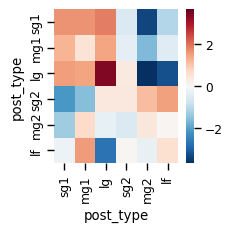

In [9]:

# Define the desired order for plotting
plot_order = ['sg1','mg1','lg','sg2','mg2','lf']

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=plot_order, columns=plot_order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

sns.set_context("paper",font_scale=1)
hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# plt.savefig('/Users/kperks/Downloads/pf_output_conditional_output_analysis.svg', format='svg', transparent=True)

### an example of shuffle result

<AxesSubplot:xlabel='post_type', ylabel='post_type'>

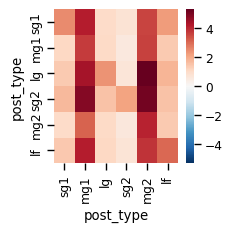

In [10]:

df_syn_shuff = deepcopy(df_syn)
mask = df_syn_shuff['pre_type'].isin(pre_groups) & df_syn_shuff['post_type'].isin(post_groups)  # Filter out rows with post_type not in post_types_order and pre_tyep not in pre_types_order
df_syn_shuff = df_syn_shuff[mask]
# Shuffle the dataframe
# df_syn_rand.loc[:,['pre']] = df_syn_rand['pre'].sample(frac = 1).values ## *** this does not work unless you re-type the pre_type column after***
shuff_rows = df_syn_shuff[['pre','x','y','z','pre_type']].sample(frac = 1)
df_syn_shuff.loc[:,['pre']] = shuff_rows['pre'].values
df_syn_shuff.loc[:,['x']] = shuff_rows['x'].values
df_syn_shuff.loc[:,['y']] = shuff_rows['y'].values
df_syn_shuff.loc[:,['z']] = shuff_rows['z'].values
df_syn_shuff.loc[:,['pre_type']] = shuff_rows['pre_type'].values

df_edges_shuff=df_syn_shuff[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

result_,order = get_conditional_output(df_edges_shuff)

cond_input_mat = pd.DataFrame(result_,columns = order, index = order)

# Reorder rows and columns
df_reordered=cond_input_mat.reindex(index=plot_order, columns=plot_order)

# Ensure the color range is centered around 0
vmin = -max(abs(df_reordered.min().min()), abs(df_reordered.max().max()))
vmax = -vmin

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.heatmap(df_reordered,
    cmap="RdBu_r",  # Diverging colormap from red to blue
    vmin=vmin,
    vmax=vmax,
    center=0)

# Patterns of connectivity (PCA)

In [11]:
def calculate_percent_total(row):
    # normalizes each pre cell to fraction total synapses per post cell type rather than number of synapses per post cell type
    total = row.sum()
    if total == 0:
        return row  # If total is 0, return the row as is (unchanged)
    else:
        return row / total  # Normalize by dividing each element by the total
#row / total 

## Use PCA module from scikit-learn decomposition

In [12]:
# change as needed based on which synapses table you import and which cell types you want to include

# post-synaptic labeling
dsource = 'pre_type'
idsource = 'pre'
dtarget = 'post_type'

# Desired pre_types and order
source_types_order = ['pf']#
# Desired post_types order
target_types_order =  ['sg1', 'mg1','lg', 'sg2','mg2','lf'] #['aff',  'sg1','mg1', 'grc', 'sg2','mg2']

### data

In [13]:
mask = df_syn['pre_type'].isin(source_types_order) & df_syn['post_type'].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

# get total synaptic weight between each pre-post cell pair
df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per post and pre_type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the fraction total synapses normalization function to each row (each pre cell)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data for each feature
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

# Perform PCA
npc = len(target_types_order)
pca_ = PCA(n_components=npc)  

pca_result = pca_.fit_transform(scaled_data)

# get loadings of dimensions onto each principal component
loadings = pca_.components_.T

# Add PCA results to the DataFrame
for i in range(npc):
    pivot_df[str(i)] = pca_result[:, i]

In [17]:
result_data = pd.DataFrame(pca_.explained_variance_ratio_.reshape(1, -1),columns=range(len(pca_.explained_variance_ratio_)))

In [18]:
pivot_df.head()

post_type,pre_type,sg1,mg1,lg,sg2,mg2,lf,0,1,2,3,4,5
pre,,,,,,,,,,,,,
27220895,pf,1,1,0,0,3,0,0.853409,0.345112,-0.191606,-1.399579,0.516352,-3.688417e-16
283546587,pf,3,3,2,0,2,1,-0.607489,0.303300,0.767703,-0.726266,0.106135,-1.206767e-15
283547027,pf,0,3,0,0,0,0,-1.814058,-2.208971,-1.291452,0.013831,0.146476,1.254623e-15
283548237,pf,0,5,2,0,2,1,-0.589853,-0.421875,-0.621634,0.122542,-0.535463,6.920581e-16
283548467,pf,1,4,0,0,0,1,-1.163594,-1.536698,0.355271,-0.196704,-0.002346,-8.420642e-17


<AxesSubplot:xlabel='0', ylabel='1'>

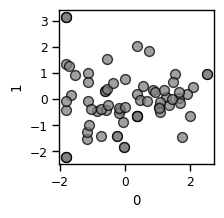

In [19]:
# plot first and second PC against each other

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)

# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

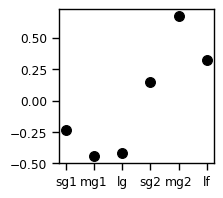

In [20]:
# plot loadings of features onto first principle component

hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(['sg1','mg1','lg','sg2','mg2','lf'],[l[0] for l in loadings],color = 'black',s=50)

### shuffle 

In [22]:
mask = df_syn['pre_type'].isin(source_types_order) & df_syn['post_type'].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in 

result_shuff = pd.DataFrame()
# Iterate the specified number of times
for i in range(50):
    # Shuffle the dataframe
    df_syn_rand = deepcopy(df_syn[mask])
    shuff_rows = df_syn_rand[['pre','pre_type']].sample(frac = 1)
    df_syn_rand.loc[:,['pre']] = shuff_rows['pre'].values
    df_syn_rand.loc[:,['pre_type']] = shuff_rows['pre_type'].values
    
    df_edges_shuff=df_syn_rand[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')
    
    # Pivot table to get sum of weights per post and pre_type
    pivot_df = df_edges_shuff.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)
    
    # Reindex columns to include only the specified pre_types in the desired order
    pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)
    
    # Reset index to turn 'post' and 'post_type' from index to columns
    pivot_df.reset_index(inplace=True)
    
    # Sort the dataframe based on post_type
    pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
    pivot_df.sort_values(dsource, inplace=True)
    pivot_df.set_index(idsource, inplace=True)
    
    # Apply the fraction total synapses normalization function to each row (each pre cell)
    norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)
    
    # Standardize the data for each feature
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(norm_df)
    
    # Perform PCA
    npc = len(target_types_order)
    pca_ = PCA(n_components=npc)  
    
    pca_result = pca_.fit_transform(scaled_data)

        # get loadings of dimensions onto each principal component
    loadings = pca_.components_.T
    
    # Add PCA results to the DataFrame
    for i in range(npc):
        pivot_df[str(i)] = pca_result[:, i]
    
    # Append the result as a row to the result_df
    result_shuff = pd.concat([result_shuff, pd.DataFrame(pca_.explained_variance_ratio_.reshape(1, -1))], ignore_index=True)

<AxesSubplot:xlabel='0', ylabel='1'>

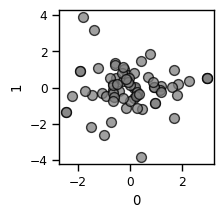

In [23]:
# plot first and second PC against each other
# data from last shuffle iteration run

hfig,ax = plt.subplots(1,figsize=(2,2))
sns.scatterplot(ax=ax,data=pivot_df,x='0',y='1',linewidth=1,color='gray',edgecolor='black',s=50,alpha = 0.75)


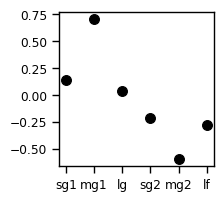

In [24]:
# plot loadings of features onto first principle component
# data from last shuffle iteration run

hfig,ax = plt.subplots(figsize = (2,2))
ax.scatter(['sg1','mg1','lg','sg2','mg2','lf'],[l[0] for l in loadings],color = 'black',s=50)

## plot comparison

Text(0, 0.5, 'explained variance')

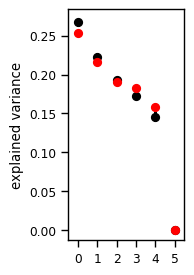

In [25]:
hfig,ax = plt.subplots(1,figsize=(1.5,3))

# plot iteration means
sns.pointplot(data = result_shuff,linestyle='',color = 'black',markersize = 5,errorbar='ci')
sns.pointplot(data=result_data,linestyle='',color = 'red',markersize = 5)

ax.set_ylabel('explained variance')
# plt.savefig(f'/Users/kperks/Downloads/pf_output_pca_compare.svg', format='svg', transparent=True)

## Use PCA module from https://erdogant.github.io/pca/pages/html/index.html

Has some useful plotting functions

In [26]:
from pca import pca

In [27]:
mask = df_syn['pre_type'].isin(source_types_order) & df_syn['post_type'].isin(target_types_order)  # Filter out rows with post_type not in post_groups and pre_type not in pre_groups
df_syn_data = df_syn[mask]

# get total synaptic weight between each pre-post cell pair
df_edges_data=df_syn_data[['pre','post','pre_type','post_type']].value_counts().reset_index(name='weight')

# Pivot table to get sum of weights per pre cell ID and post type
pivot_df = df_edges_data.pivot_table(values='weight', index=[idsource, dsource], columns=dtarget, aggfunc='sum', fill_value=0)

# Reindex columns to include only the specified pre_types in the desired order (for plotting purposes later)
pivot_df = pivot_df.reindex(columns=target_types_order, fill_value=0)

# Reset index to turn 'post' and 'post_type' from index to columns
pivot_df.reset_index(inplace=True)

# Sort the dataframe based on post_type
pivot_df[dsource] = pd.Categorical(pivot_df[dsource], categories=source_types_order, ordered=True)
pivot_df.sort_values(dsource, inplace=True)
pivot_df.set_index(idsource, inplace=True)

# Apply the fraction total synapses normalization function to each row (each pre cell)
norm_df = pivot_df.select_dtypes(include='number').apply(calculate_percent_total, axis=1)

# Standardize the data for each feature
scaler = StandardScaler()
scaled_data = scaler.fit_transform(norm_df)

scaled_data = pd.DataFrame(scaled_data,columns=norm_df.columns)

In [28]:
scaled_data.head()

post_type,sg1,mg1,lg,sg2,mg2,lf
0,0.634936,-0.484841,-0.601919,-0.443921,1.218777,-0.653114
1,1.076934,-0.193661,0.171025,-0.443921,-0.377637,-0.151371
2,-0.580557,2.718138,-0.601919,-0.443921,-1.071730,-0.653114
3,-0.580557,0.716276,0.248319,-0.443921,-0.308227,-0.101196
4,0.432354,1.383563,-0.601919,-0.443921,-1.071730,0.266748


In [29]:
model = pca()

results = model.fit_transform(scaled_data);

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [6] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [5] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [6] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'Cumulative explained variance\n 5 Principal Components explain [100.0%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

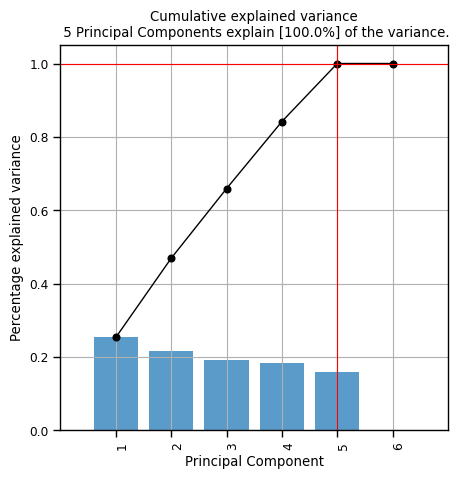

In [30]:
model.plot(figsize=(5,5))

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

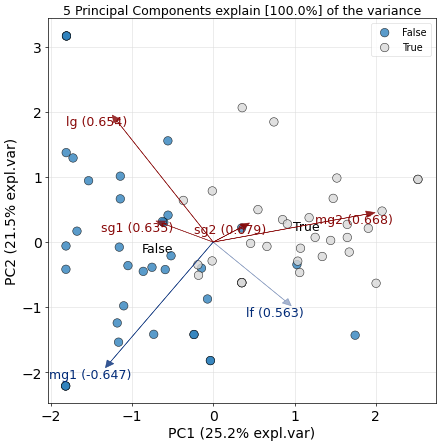

In [31]:
X_feat = norm_df['mg2'].values>np.mean(norm_df['mg2'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg2.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

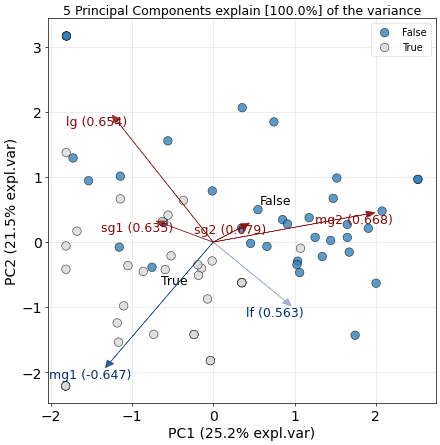

In [32]:
X_feat = norm_df['mg1'].values>np.mean(norm_df['mg1'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)
# plt.savefig('/Users/kperks/Downloads/pf_output_PCA_loadings_labeled-by-mg1.svg', format='svg', transparent=True)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.
[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <AxesSubplot:title={'center':'5 Principal Components explain [100.0%] of the variance'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

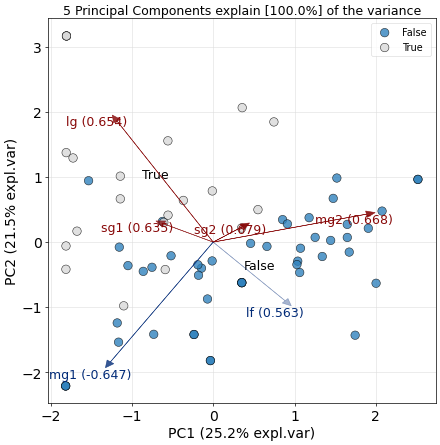

In [33]:
X_feat = norm_df['lg'].values>np.mean(norm_df['lg'].values)
model.biplot(figsize=(10, 10), dpi=50,labels=X_feat)

[scatterd] >INFO> Create scatterplot


[scatterd]> WARNING use the standardized verbose status. The status [1-6] will be deprecated in future versions.


(<Figure size 500x500 with 1 Axes>,
 <Axes3DSubplot:title={'center':'Color on flavanoids (Gray colored samples are > mean)'}, xlabel='PC1 (25.2% expl.var)', ylabel='PC2 (21.5% expl.var)'>)

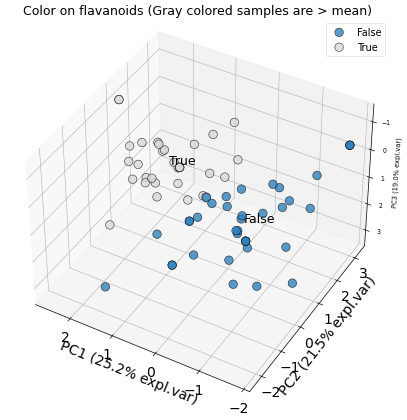

In [34]:

# Grap the values for mg2 syn and # Color based on mean
X_feat = norm_df['mg2'].values>np.mean(norm_df['mg2'].values)

# Scatter based on discrete color
model.scatter3d(labels=X_feat, title='Color on flavanoids (Gray colored samples are > mean)',figsize=(10,10),dpi=50)

# 3d scatter plot
# model.scatter3d(labels=color_label, title='Color on flavanoids (Gray colored samples are > mean)')